# Creating your own dataset  - off-ADHD and CTRL

*by: Francisco Ingham and Jeremy Howard. Inspired by [Adrian Rosebrock](https://www.pyimagesearch.com/2017/12/04/how-to-create-a-deep-learning-dataset-using-google-images/)*

In [2]:
from fastai.vision import *

In [3]:
path = Path('GASF')
#dest = path/folder
#dest.mkdir(parents=True, exist_ok=True)

In [ ]:
path.ls()

get_transforms()

np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=[[],[]], size=224).normalize(imagenet_stats)

In [4]:
def get_float_labels_combine(y):
    label = ((y.parts[-1].split('_')[-1]).split('.')[0])
    if label == 'Ctrl' or label == 'on-ADHD':
        return 'Ctrlormed'
    else:
        return label

In [5]:
def get_float_labels(y):
    label = ((y.parts[-1].split('_')[-1]).split('.')[0])
    return label

In [6]:
np.random.seed(42)
tfms = [[],[]]
fnames = get_image_files(path)

In [7]:
fnames_nomeds = []
for onefile in fnames:
    if "on-ADHD" not in onefile.parts[-1]:
        fnames_nomeds.append(onefile)
fnames_nomeds
len(fnames_nomeds)

5873

In [24]:
data = (ImageList(fnames_nomeds)
        .split_by_rand_pct(0.2)
        .label_from_func(get_float_labels)
        .transform(tfms, size=224)
        .databunch())

In [29]:
data.classes

['Ctrl', 'off-ADHD']

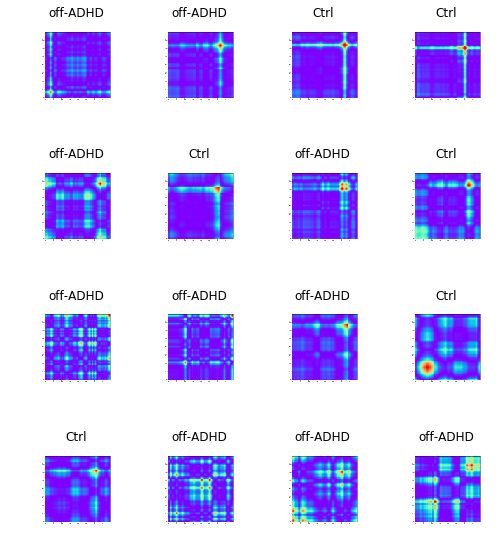

In [14]:
data.show_batch(rows=4, figsize=(7,8))

In [50]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['Ctrl', 'off-ADHD'], 2, 4699, 1174)

## Train model

In [30]:
learn = cnn_learner(data, models.resnet50, metrics=error_rate)

In [32]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,0.852702,0.715436,0.390971,01:34
1,0.665323,0.676640,0.368825,01:30
2,0.564336,0.652591,0.355196,01:31
3,0.471978,0.664667,0.357751,01:31


In [ ]:
learn.unfreeze()

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [33]:
learn.fit_one_cycle(2, max_lr=2e-6)

epoch,train_loss,valid_loss,error_rate,time
0,0.413197,0.660923,0.352641,01:31
1,0.417771,0.662777,0.357751,01:31


In [34]:
learn.save('stage-tuned_NaNCleaned_fac80_rainbow_2class_nomeds_ADHD_ROC')

## Interpretation

In [26]:
learn.load('stage-tuned_NaNCleaned_fac80_rainbow_2class_nomeds_ADHD_ROC');

In [35]:
interp = ClassificationInterpretation.from_learner(learn)

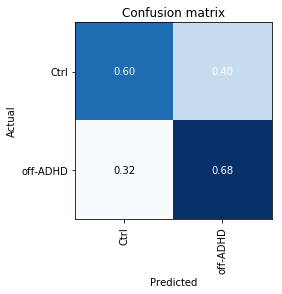

In [36]:
interp.plot_confusion_matrix(figsize=(4,4),normalize=True)

In [ ]:
interp.plot_confusion_matrix(figsize=(5,5),normalize=False)

In [ ]:
learn.show_results()

In [ ]:
#interp.plot_top_losses(9,heatmap=False)

In [ ]:
interp.plot_top_losses(9,heatmap=True)

In [ ]:
from IPython.display import Image

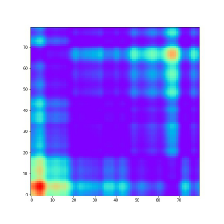

In [31]:
img = learn.data.train_ds[0][0]
img
#learn.predict(img)

In [32]:
learn.predict(img)

(Category Ctrl, tensor(0), tensor([0.6588, 0.3412]))

In [45]:
preds_and_labels = learn.get_preds(ds_type=DatasetType.Valid)

In [46]:
y_score = preds_and_labels[0][:,1].numpy()

array([0.86395 , 0.938069, 0.949846, 0.769928, ..., 0.368447, 0.878274, 0.22    , 0.099538], dtype=float32)

In [54]:
y_test = preds_and_labels[1]
y_test

tensor([1, 1, 0,  ..., 0, 1, 0])

In [62]:
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn.metrics

In [57]:
# Compute ROC curve and ROC area for each class


NameError: name 'n_classes' is not defined

In [65]:
fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_score)

In [67]:
roc_auc = sklearn.metrics.auc(fpr, tpr)

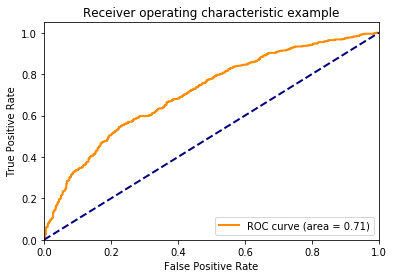

In [70]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()